<br>

## 필요한 모듈

<br>

In [7]:

import tensorflow as tf
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt

from skimage.metrics import peak_signal_noise_ratio, structural_similarity

import imageio

<br>

# 프로젝트 1-1. <br>

## 직접 고른 이미지로 SRGAN 실험하기 <br>

고해상도 원본 이미지로 실험 후 원본과 비교

<br>

<br>

## 이미지 준비 <br><br>

- 고해상도 이미지 불러오기 <br>
이미지 사이즈 : (1098, 770)
- 고해상도 -> 저해상도 변환 <br>
( cv2.resize() 사용 )

<br>

<br>

## 이미지 준비 <br><br>

- 고해상도 이미지 불러오기 <br>
이미지 사이즈 : (1098, 770)
- 고해상도 -> 저해상도 변환 <br>
( cv2.resize() 사용 )

<br>

In [8]:
print(cv2.__version__)

4.5.1


(770, 1098, 3)
(192, 274, 3)


Text(0.5, 1.0, 'Origin_lr')

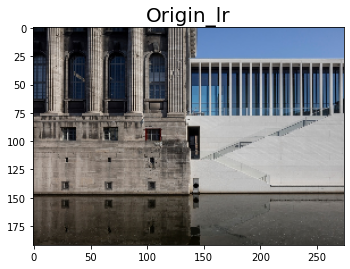

In [9]:
# 고해상도 이미지 불러와 저해상도 이미지로 리사이즈

my_image_path = os.getenv('HOME')+'/aiffel/super_resolution_GAN/images/David_01.jpg'

#- OpenCV로 이미지를 읽어오기
hr = cv2.imread(my_image_path, cv2.IMREAD_UNCHANGED)
# 1/4 의 크기로 Resize
lr = cv2.resize(hr, dsize=(0,0), fx=0.25, fy=0.25, interpolation=cv2.INTER_CUBIC)

#- 출력용 이미지 별도 보관
img_01_lr = lr.copy()

# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)

# 리사이즈 이미지 및 이미지 사이즈 확인
print(hr.shape)
print(lr.shape)
plt.figure()
plt.imshow(lr)
plt.title("Origin_lr", fontsize=20)

<br>

## Super Resolution 적용 <br><br>

- Interpolation 을 통해 고해상도 이미지 생성해보기 <br>
- SRGAN generator 모델을 통해 고해상도 이미지 생성해보기

<br>

<br>

### Super Resolution 적용 : Bicubic Interpolation 이용 <br><br>

bicubic interpolation 을 적용해 이미지를 4배 크기로 크게 변환 <br><br>

__cv2.resize()__ 내의 인자 __interpolation__ 보간법 종류 결정 <br>
- interpolation=cv2.INTER_CUBIC : 'bicubic interpolation'

<br>

In [10]:
# Interpolation 을 통한 Super Resolution
# OpenCV 의 resize() 이용

bicubic_hr = cv2.resize(
    lr, 
    dsize=(1098, 770), interpolation=cv2.INTER_CUBIC)

print(bicubic_hr.shape)
plt.figure()
plt.imshow(bicubic_hr)
plt.title("Bicubic", fontsize=20)

(770, 1098, 3)


Text(0.5, 1.0, 'Bicubic')

<br>

### Super Resolution 적용 : SRGAN generator 모델 이용 <br><br>

사전에 학습된 srgan_G.h5 모델을 불러와 사용합니다.

<br>

In [11]:
# 사전 학습된 모델 srgan_G.h5 불러오기

model_file = os.getenv('HOME')+'/aiffel/super_resolution_GAN/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

(770, 1098, 3)


Text(0.5, 1.0, 'SRGAN')

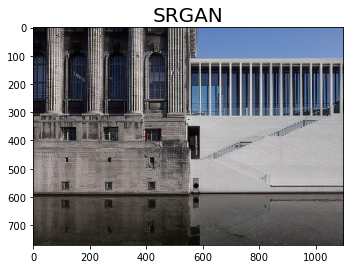

In [12]:
# 학습된 모델 테스트하는 함수

def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

srgan_hr_temp = apply_srgan(lr)
# 저해상도 이미지 변환과정에서 이미지 사이즈 오차가 생기므로 resize()로 보정
srgan_hr = cv2.resize(
    srgan_hr_temp, 
    dsize=(1098, 770), interpolation=cv2.INTER_CUBIC)

# 리사이즈 이미지 사이즈 확인
print(srgan_hr.shape)
plt.figure()
plt.imshow(srgan_hr)
plt.title("SRGAN", fontsize=20)

<br>

## Super Resolution 결과 평가 : 정성적 평가 <br><br>

### 일부 영역을 잘라내어 시각적으로 비교 <br><br>

3개 이미지를 나란히 시각화 <br>
- "Bicubic" : bicubic interpolation의 결과 <br>
- "SRGAN" : SRGAN의 결과 <br>
- "Origin_hr" : 원래 고해상도 이미지

<br>

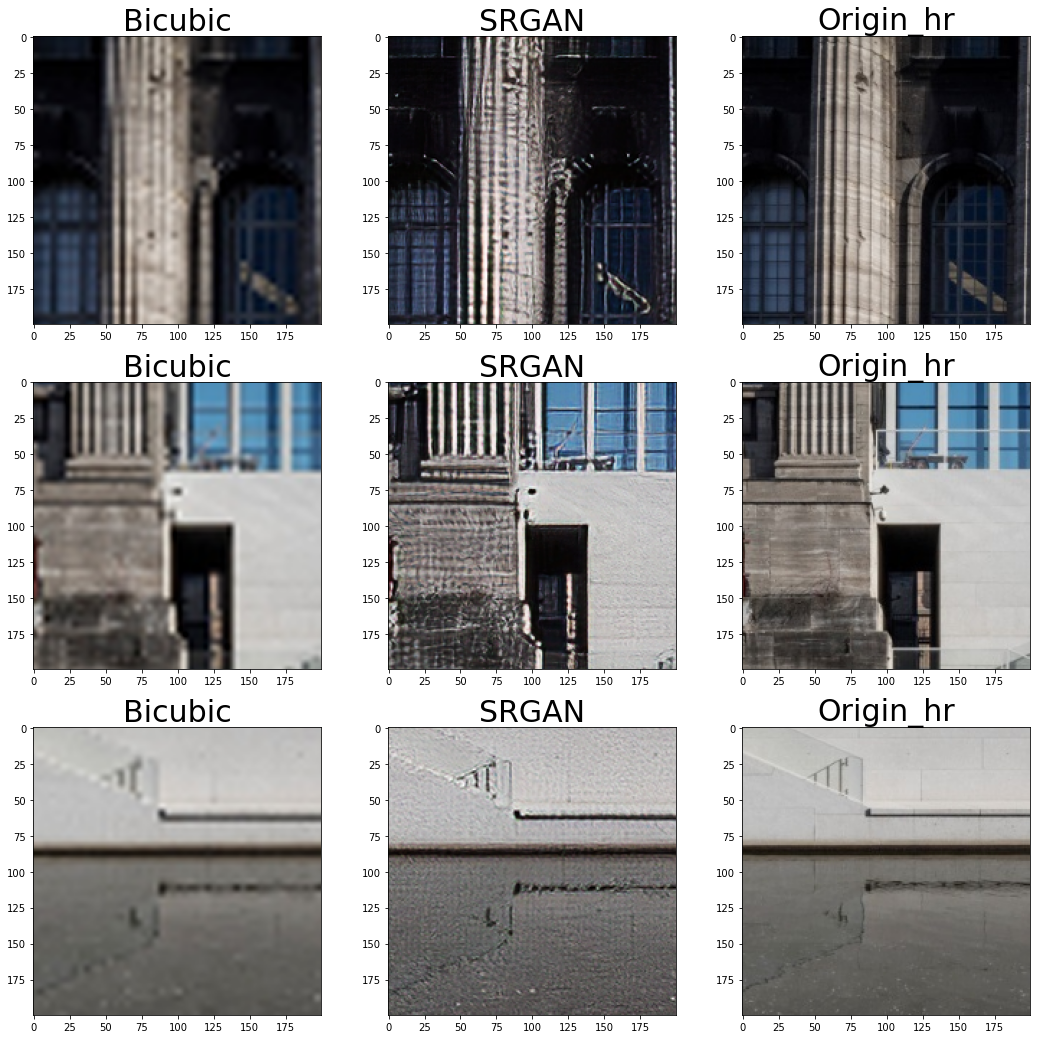

In [13]:
# 일부 영역만 시각화하여 비교 출력

# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(0,0), (250,450), (500,750)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    img3 = crop(hr, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "Origin_hr"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

<br>

## Super Resolution 결과 평가 : 정량적 평가 <br><br>


### Super Resolution 결과를 평가하는 정량적 방법 <br>
( 결과가 높을수록 비교하려는 영상이 원본 영상 품질에 가까움 ) <br><br>

- __PSNR__ : peak_signal_noise_ratio <br>
이미지를 압축했을 때 화질이 얼마나 손실되었는지 평가 <br><br>

- __SSIM__ : structural_similarity <br>
이미지의 구조 정보를 고려하여 얼마나 구조 정보를 변화시키지 않았는지를 계산 <br><br><br>



### Scikit-image 에서 PSNR 과 SSIM <br><br>

Scikit-image 라이브러리를 이용해 쉽게 계산 <br>
```
from skimage.metrics 
import peak_signal_noise_ratio, structural_similarity
```
<br>

- peak_signal_noise_ratio : PSNR 계산 <br><br>

- structural_similarity : SSIM 계산

<br>

/home/ssac29/anaconda3/envs/aiffel/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


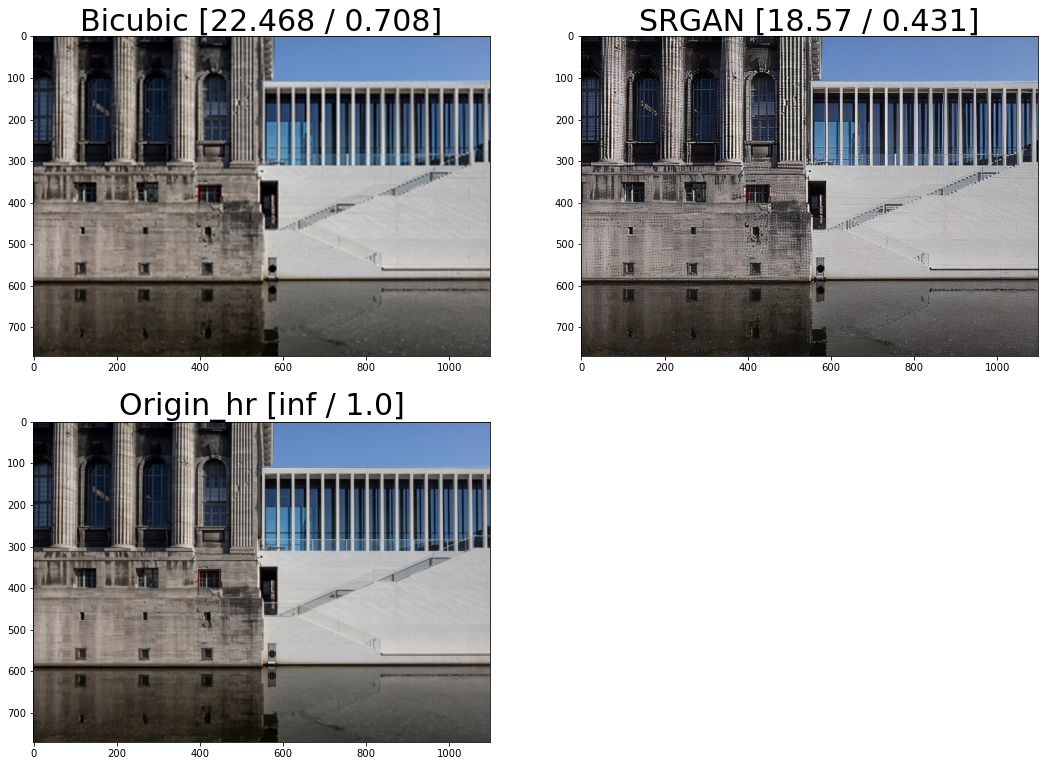

In [14]:
# 전체 이미지 비교
# "Bicubic", "SRGAN", "Origin_hr" 세 이미지에 대해 PSNR, SSIM 으로 정량적 평가

images = [bicubic_hr, srgan_hr, hr]
titles = ["Bicubic", "SRGAN", "Origin_hr"]

# 각 이미지에 대해 PSNR을 계산하고 반올림합니다.
psnr = [round(peak_signal_noise_ratio(hr, i), 3) for i in images]

# 각 이미지에 대해 SSIM을 계산하고 반올림합니다.
ssim = [round(structural_similarity(hr, i, multichannel=True), 3) for i in images]

# 이미지 제목에 PSNR과 SSIM을 포함하여 시각화 합니다. 
plt.figure(figsize=(18,13))
for i in range(len(images)):
    plt.subplot(2,2,i+1)
    plt.imshow(images[i])
    plt.title(titles[i] + f" [{psnr[i]} / {ssim[i]}]", fontsize=30)

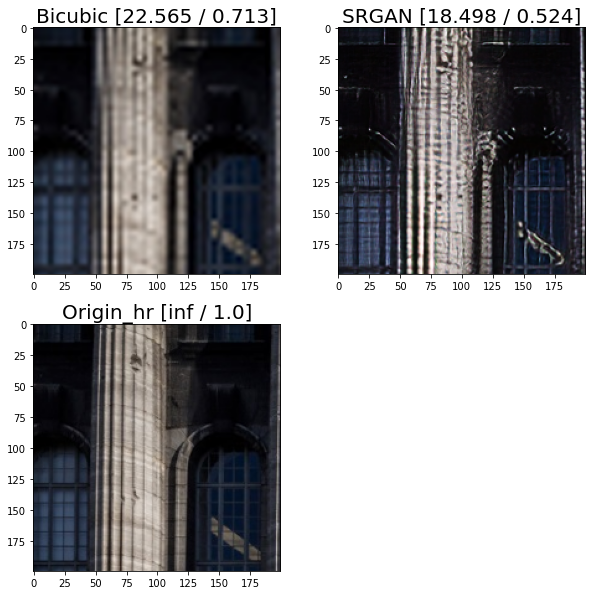

In [15]:
# 부분 이미지 비교
# "Bicubic", "SRGAN", "Origin_hr" 세 이미지에 대해 PSNR, SSIM 으로 정량적 평가

# 건물 기둥부분 crop 이미지 비교
left_top = (0,0)
crop_images = [crop(i, left_top, 200, 200) for i in images]

# 각 이미지에 대해 PSNR을 계산하고 반올림합니다.
psnr = [round(peak_signal_noise_ratio(crop_images[-1], i), 3) for i in crop_images]

# 각 이미지에 대해 SSIM을 계산하고 반올림합니다.
ssim = [round(structural_similarity(crop_images[-1], i, multichannel=True), 3) for i in crop_images]

# 이미지 제목에 PSNR과 SSIM을 포함하여 시각화 합니다. 
plt.figure(figsize=(10,10))
for i in range(len(images)):
    plt.subplot(2,2,i+1)
    plt.imshow(crop_images[i])
    plt.title(titles[i] + f" [{psnr[i]} / {ssim[i]}]", fontsize=20)

<br>

## 총평 <br><br>

Super Resolution 에 대한 정성적 평가 결과, <br>
Interpolation 기법을 이용한 이미지 보다 SRGAN 모델을 이용한 이미지가 더 원본 고해상도 이미지와 비슷해 보입니다. <br><br>

Super Resolution 에 대한 정량적 평가 결과, <br>
Interpolation 기법을 이용한 이미지가 SRGAN 모델을 이용한 이미지 보다 PSNR 과 SSIM 값 모두 더 높게 나왔습니다. <br>
( 이미지의 부분마다 PSNR 과 SSIM 값은 다르게 나오나, 여러 경우 모두 동일 결과 ) <br><br>

이러한 결과를 미루어 볼 때, <br>
이미지가 얼마나 자연스러운지를 평가할 때, 정량적으로 평가한 결과와 정성적으로 평가한 결과가 충분히 다를 수 있음을 알 수 있습니다. 사람 눈으로 보기에 더 자연스럽고 보기 좋은 쪽은 SRGAN 모델을 이용한 이미지였고, 사람들이 보기위한 이미지 생성에 있어서는 GAN 모델을 통한 이미지 생성(또는 복원)이 더 좋을 것으로 생각됩니다.

<br>

<br>

# 프로젝트 1-2. <br>

## 직접 고른 이미지로 SRGAN 실험하기 <br>

저해상도 이미지로 실험

<br>

<br>

## 이미지 준비 <br><br>

- 저해상도 이미지 불러오기 <br>
이미지 사이즈 : (300, 200)

<br>

(200, 300, 3)


Text(0.5, 1.0, 'Origin_lr')

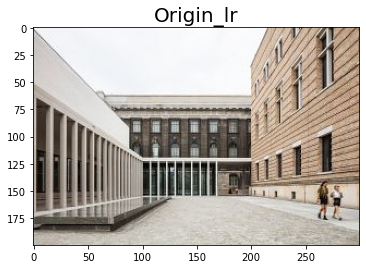

In [16]:
# 저해상도 이미지 불러오기

my_image_path = os.getenv('HOME')+'/aiffel/super_resolution_GAN/images/David_lr.jpg'

#- OpenCV로 이미지를 읽어오기
origin_lr = cv2.imread(my_image_path, cv2.IMREAD_UNCHANGED)

#- 출력용 이미지 별도 보관
David_lr = origin_lr.copy()

# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
origin_lr = cv2.cvtColor(origin_lr, cv2.COLOR_BGR2RGB)

# 리사이즈 이미지 및 이미지 사이즈 확인
print(origin_lr.shape)
plt.figure()
plt.imshow(origin_lr)
plt.title("Origin_lr", fontsize=20)

<br>

## Super Resolution 적용 <br><br>

- Interpolation 을 통해 고해상도 이미지 생성해보기 <br>
- SRGAN generator 모델을 통해 고해상도 이미지 생성해보기

<br>

<br>

### Super Resolution 적용 : Bicubic Interpolation 이용 <br><br>

bicubic interpolation 을 적용해 이미지를 4배 크기로 크게 변환 <br><br>

__cv2.resize()__ 내의 인자 __interpolation__ 보간법 종류 결정 <br>
- interpolation=cv2.INTER_CUBIC : 'bicubic interpolation'

<br>

(800, 1200, 3)


Text(0.5, 1.0, 'Bicubic')

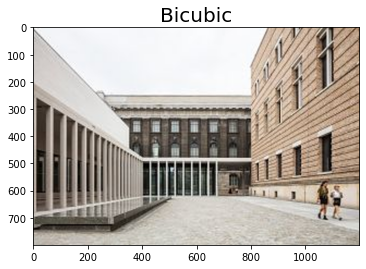

In [17]:
# Interpolation 을 통한 Super Resolution
# OpenCV 의 resize() 이용

bicubic_hr_02 = cv2.resize(
    origin_lr, 
    dsize=(0,0), fx=4, fy=4, interpolation=cv2.INTER_CUBIC)

print(bicubic_hr_02.shape)
plt.figure()
plt.imshow(bicubic_hr_02)
plt.title("Bicubic", fontsize=20)

<br>

### Super Resolution 적용 : SRGAN generator 모델 이용 <br><br>

사전에 학습된 srgan_G.h5 모델을 불러와 사용합니다.

<br>

In [18]:
# 사전 학습된 모델 srgan_G.h5 불러오기
# # 사전 학습된 모델 srgan_G.h5 불러오기

model_file = os.getenv('HOME')+'/aiffel/super_resolution_GAN/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

(800, 1200, 3)


Text(0.5, 1.0, 'SRGAN')

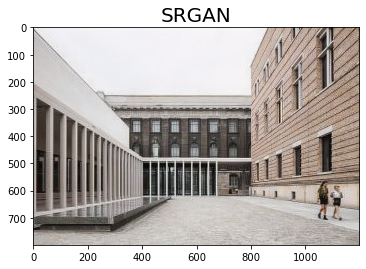

In [19]:
# 학습된 모델 테스트하는 함수

def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

srgan_hr_temp_02 = apply_srgan(origin_lr)

# 저해상도 이미지 변환과정에서 이미지 사이즈 오차가 생기므로 resize()로 보정
srgan_hr_02 = cv2.resize(
    srgan_hr_temp_02, 
    dsize=(1200, 800), interpolation=cv2.INTER_CUBIC)

# 리사이즈 이미지 사이즈 확인
print(srgan_hr_02.shape)
plt.figure()
plt.imshow(srgan_hr_02)
plt.title("SRGAN", fontsize=20)

<br>

## Super Resolution 결과 평가 : 정성적 평가 <br><br>

### 일부 영역을 잘라내어 시각적으로 비교 <br><br>

3개 이미지를 나란히 시각화 <br>
- "Bicubic" : bicubic interpolation의 결과 <br>
- "SRGAN" : SRGAN의 결과 <br>
- "Origin_hr" : 원래 고해상도 이미지

<br>

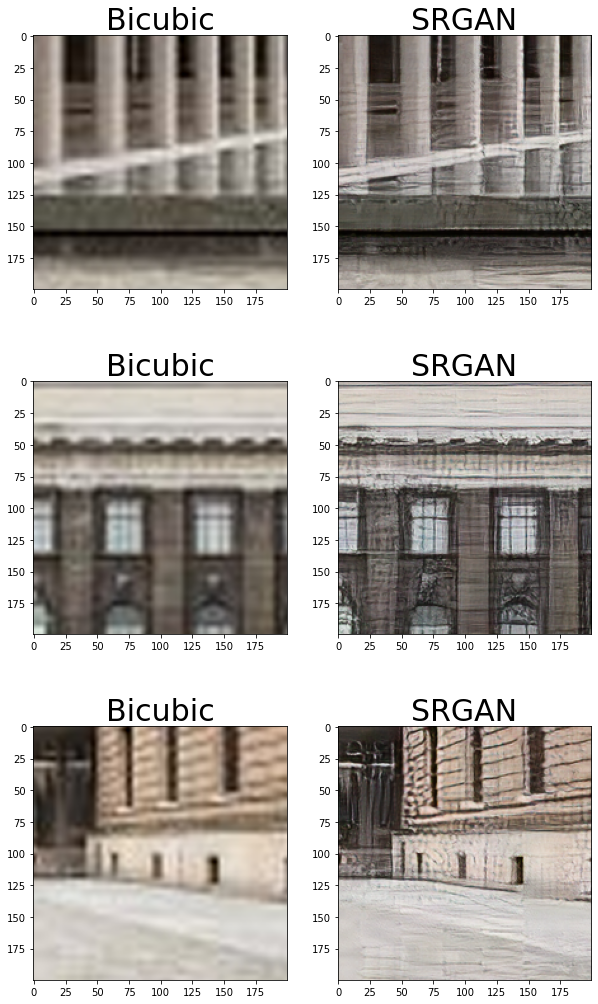

In [20]:
# 일부 영역만 시각화하여 비교 출력

# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(570,50), (250,450), (500,750)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr_02, left_top, 200, 200)
    img2 = crop(srgan_hr_02 , left_top, 200, 200)
    images.extend([img1, img2])

labels = ["Bicubic", "SRGAN"] * 3

plt.figure(figsize=(10,18))
for i in range(6):
    plt.subplot(3,2,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

<br>

## Super Resolution 결과 평가 : 정량적 평가 <br><br>

비교 대상이 되는 고화질 원본 이미지가 없으므로 수행할 수 없습니다 !

<br>

<br>

## 총평 <br><br>

Super Resolution 에 대한 정성적 평가 결과, <br>
Interpolation 기법을 이용한 이미지 보다 SRGAN 모델을 이용한 이미지가 더 뚜렷하고 자연스러워 보입니다. <br><br>

이러한 결과를 미루어 볼 때, <br>
원본 이미지가 없는 저해상도 이미지를 고해상도로 복원할 경우, 평가 지표가 눈으로 보기에 만족스러움을 평가하는 정성적 평가밖에 없기 때문에 원본 고해상도 이미지가 있는 경우보다도 더욱 SRGAN 모델을 사용하여 Super Resolution 을 수행하는 것이 좋다고 보여집니다. <br><br>

참고. <br>
두 이미지 모두 원본에 있는 '사람'이 없어진 것을 확인할 수 있습니다.

<br>

<br>

# 프로젝트 2. <br>

## SRGAN 을 이용해 고해상도 gif 생성하기 <br><br>

단일 이미지가 아닌 영상에 대해 Super Resolution을 적용한 사례 <br>
미리 학습된 SRGAN을 이용해 저해상도 영상을 고해상도 영상으로 바꿔보는 프로젝트 <br><br>

참고. <br>
실제로 동영상의 Super Resolution은 시간 순서에 따른 다수의 프레임 정보를 고려하는 것이 더 좋지만, 처음부터 학습시키기에 많은 시간이 소요됩니다. 여기서는 이전에 사용했던 SRGAN을 이용해 한 프레임씩 고해상도 이미지로 변환 시켜 모든 프레임에 대해 적용하고, 그 프레임들을 합쳐 동영상으로 만들어 봅시다.

<br>

<br>

## 이미지 준비 <br><br>

- gif 이미지 불러오기 <br>
이미지 사이즈 : (282, 252)

<br>

In [21]:
# gif 이미지 불러오기
my_image_path = os.getenv('HOME')+'/aiffel/super_resolution_GAN/gif/metro_lr.gif'

# 다운받은 파일의 경로를 설정해 주세요.
gif = cv2.VideoCapture(my_image_path)

isTrue = True
frames = []     # frames 리스트 안에 각각의 프레임이 들어 있습니다.

while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 35
frame 크기 : (252, 282, 3)


<br>

## 프레임별 Super Resolution 적용 <br><br>

Bicubic Interpolation과 SRGAN을 이용해 각각의 가로, 세로 픽셀 수를 4배로 늘려봅시다. <br>
Super Resolution이 완료된 각각의 결과를 frames_sr이라는 리스트에 넣습니다. <br><br>

- Interpolation 을 통해 고해상도 이미지 생성해보기 <br>
- SRGAN generator 모델을 통해 고해상도 이미지 생성해보기

<br>

<br>

### Super Resolution 적용 : Bicubic Interpolation 이용 <br><br>

bicubic interpolation 을 적용해 이미지를 4배 크기로 크게 변환 <br><br>

__cv2.resize()__ 내의 인자 __interpolation__ 보간법 종류 결정 <br>
- interpolation=cv2.INTER_CUBIC : 'bicubic interpolation'

<br>

In [22]:
# Interpolation 을 이용하여 Super Resolution 적용한 gif 이미지 저장
# Bicubic Interpolation : OpenCV 의 resize() 이용

frames_sr = []

for i in frames:
    bicubic_hr_gif = cv2.resize(i, dsize=(0,0), fx=4, fy=4, interpolation=cv2.INTER_CUBIC)
    frames_sr.append(bicubic_hr_gif)

imageio.mimsave("metro_hr_Interpolation.gif", frames_sr)

<br>

### Super Resolution 적용 : SRGAN generator 모델 이용 <br><br>

사전에 학습된 srgan_G.h5 모델을 불러와 사용합니다.

<br>

In [23]:
# 사전 학습된 모델 srgan_G.h5 불러오기
# # 사전 학습된 모델 srgan_G.h5 불러오기

model_file = os.getenv('HOME')+'/aiffel/super_resolution_GAN/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [24]:
# srgan_G.h5 모델을 이용하여 Super Resolution 적용한 gif 이미지 저장

# 학습된 모델 테스트하는 함수
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

frames_sr = []

for i in frames:
    srgan_hr_gif = apply_srgan(i)
    frames_sr.append(srgan_hr_gif)

imageio.mimsave("metro_hr_SRGAN.gif", frames_sr)

<br>

## gif 결과 시각화 <br><br>


### [저화질 원본 gif](https://drive.google.com/uc?id=1y9UelgYuFqA5ukyFt3JQdxwGAZRdr-Yr) <br>

<img src="https://drive.google.com/uc?id=1y9UelgYuFqA5ukyFt3JQdxwGAZRdr-Yr" alt="metro_lr" width="800"> <br><br>


### [고화질 Interpolation gif](https://drive.google.com/uc?id=14I9loD3hu9IDaa-zpOanHQk2omG76ARQ) <br>

<img src="https://drive.google.com/uc?id=14I9loD3hu9IDaa-zpOanHQk2omG76ARQ
" alt="metro_hr_Interpolation" width="800"> <br><br>


### [고화질 SRGAN gif](https://drive.google.com/uc?id=1P2MkB-VSzBUXaNER5vzglgRUHT8s-Vh8) <br>

<img src="https://drive.google.com/uc?id=1P2MkB-VSzBUXaNER5vzglgRUHT8s-Vh8" alt="metro_hr_SRGAN" width="800"> <br><br>



<br>

<br>

<br>

## 총평 <br><br>

### 화질개선에 대한 평가 <br><br>

Bicubic Interpolation 을 통해 개선된 고화질 gif 도 저화질 원본 gif 보다 약간의 화질 개선이 이루어 졌습니다. <br>
SRGAN 학습모델을 통해 개선된 고화질 gif 는 저화질 원본 gif 보다 월등히 화질 개선이 이루어 졌습니다. <br><br>

원본 데이터가 없기에 얼마나 정확하게 복원하였는 여부는 알 수 없으나, <br>
시각적으로 보기에 SRGAN 모델이 더 뚜렷하고 자연스럽게 영상 데이터를 Super Resolution 해 주는 것으로 보입니다. <br><br><br>


### 이미지 초점에 따른 화질개선 <br><br>

SRGAN 모델을 통해 고화질로 개선된 gif 이미지를 보면, <br>
전경의 이미지는 굉장히 디테일하게 묘사되어있고, 원경의 이미지는 초점에 맞지 않아 blur 된 것 처럼 보입니다. <br>
SRGAN 모델이 이미지의 초점(focus)에 따라 Super Resolution 을 차등 적용하는 것 처럼 보입니다. <br>
SRGAN 모델이 이미지의 초점(focus)을 구분하는지 여부에 대해 더 찾아보고 이를 규명하면 좋을 것 같습니다. <br><br><br>



### 영상 데이터에서의 화질 개선 <br><br>

SRGAN 모델을 통해 개선된 이미지는 우리 눈으로 보았을 때 충분히 고화질의 이미지로 묘사된 것을 확인할 수 있었습니다. <br>
하지만 실루엣이나 텍스쳐 등의 디테일한 표현에서 원본과 다르거나 현실과 미세하게 괴리가 있는 부분이 함께 나타납니다. <br>
이러한 SRGAN 의 단점은 프레임에 따라 빠르게 움직이는 '영상'으로 표현될 때는 우리 눈에 잘 인지되지 않습니다. <br>
따라서, SRGAN generator 모델을 통한 화질개선은 영상 데이터의 화질개선에서 굉장히 좋은 효과를 볼 수 있는 것으로 보입니다.

<br>